In [12]:
import clip
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import torch

from conconchi_dataset import ConConChi
from model import Model, personalize_for_concept
from prompts import PROMPT_LIST

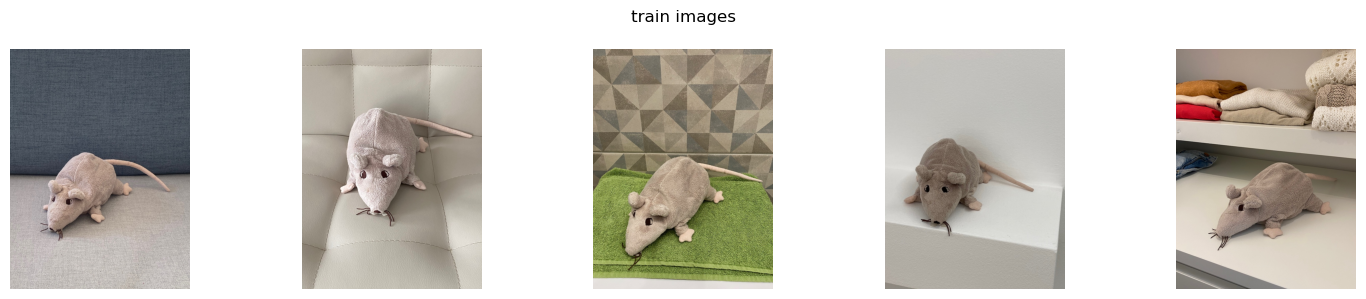

In [13]:
# Get paths to train images for a personal concept and visualize. In this example, we'll use concept (#11) from ConConChi.

dataset = ConConChi('./data/conconchi')
concept = 11
train_imgs = dataset.get_train_images_for_concept(concept)

def visualize_images_from_paths(image_paths, plt_title=""):
    images = [Image.open(path) for path in image_paths]
    n = len(images)
    fig, axs = plt.subplots(1, n, figsize=(n * 3, 3))
    plt.suptitle(plt_title)
    
    if n == 1:
        axs = [axs]

    for i, img in enumerate(images):
        axs[i].imshow(img)
        axs[i].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_images_from_paths(train_imgs, plt_title="train images")



In [20]:
# Load CLIP model
clip_model_name = "ViT-L/14"
clip_model, transform = clip.load(clip_model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model.to(device)
model = Model(clip_model)

# Load pre-computed CLIP image features for the train images and retrieval set
train_feats = dataset.get_train_feats_for_concept(concept, model=clip_model_name.replace('/', '-'))
retrieval_images = dataset.get_retrieval_pool_images()
retrieval_feats = dataset.get_retrieval_pool_feats(model=clip_model_name.replace('/', '-'))

In [16]:
# Sample training text prompts
concept_identifier = 'sks'
train_prompts = random.sample(PROMPT_LIST, len(train_feats))
train_prompts = [prompt.replace('*', concept_identifier) for prompt in train_prompts]
print(train_prompts)

['An image showing sks', 'This photo shows sks', 'This is sks', 'A scene containing sks', 'sks can be seen in this picture']


In [ ]:
# train low-rank personal parameter update
lr = 1e-3
regularization_weight = 0.35
num_iters = 50

v_lora_A, v_lora_B = personalize_for_concept(model, train_prompts, torch.tensor(train_feats).to(device), lr, regularization_weight, num_iters)

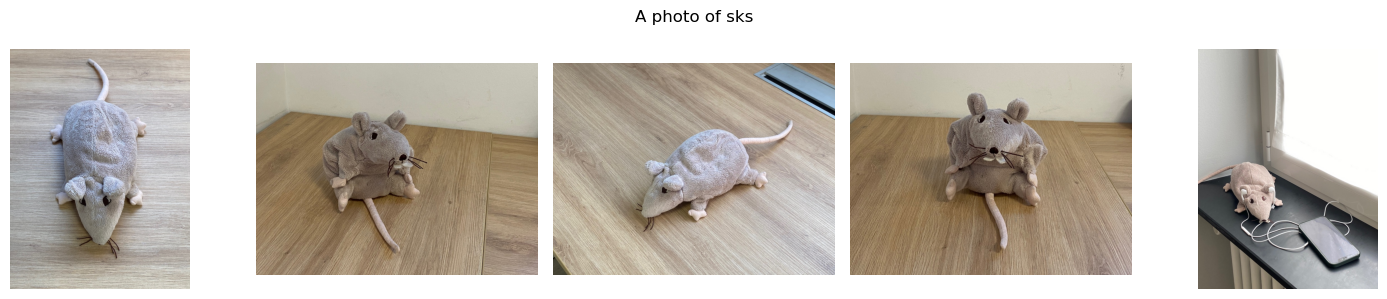

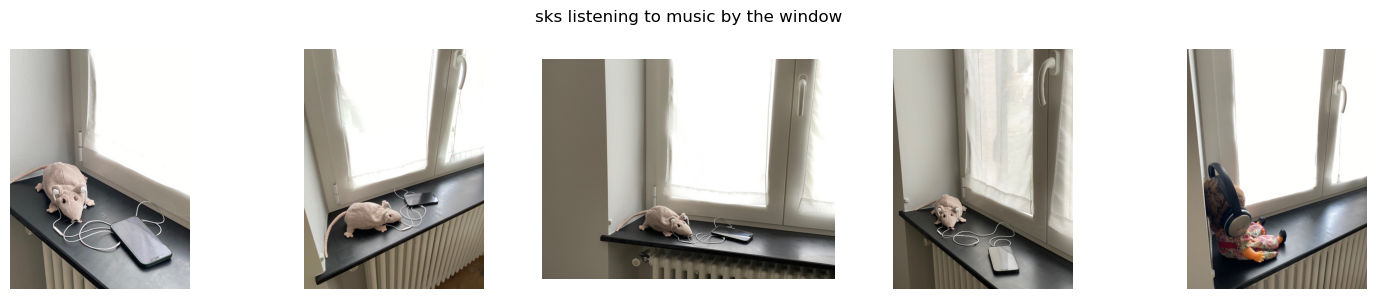

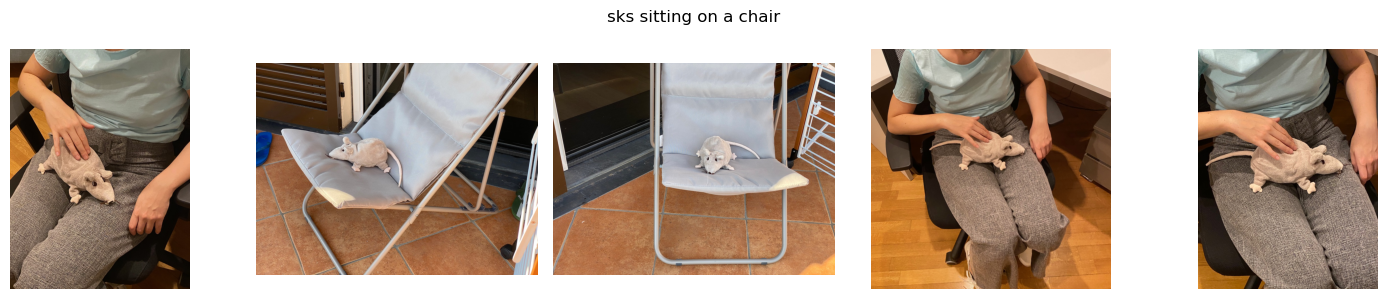

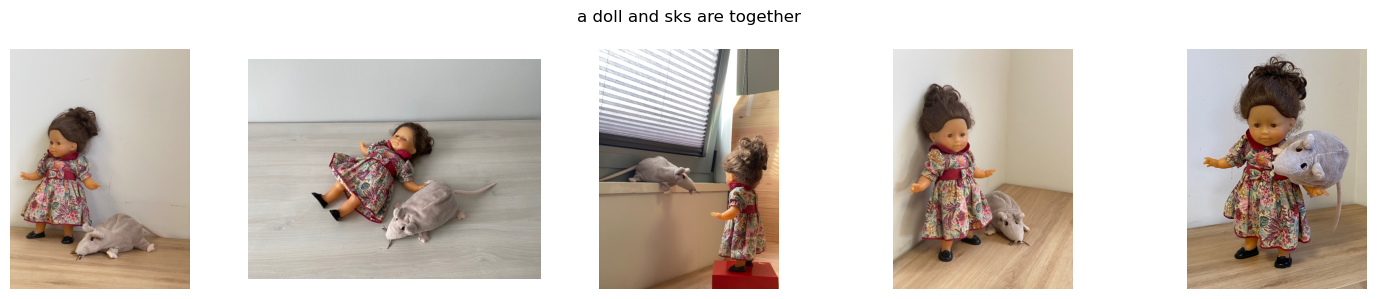

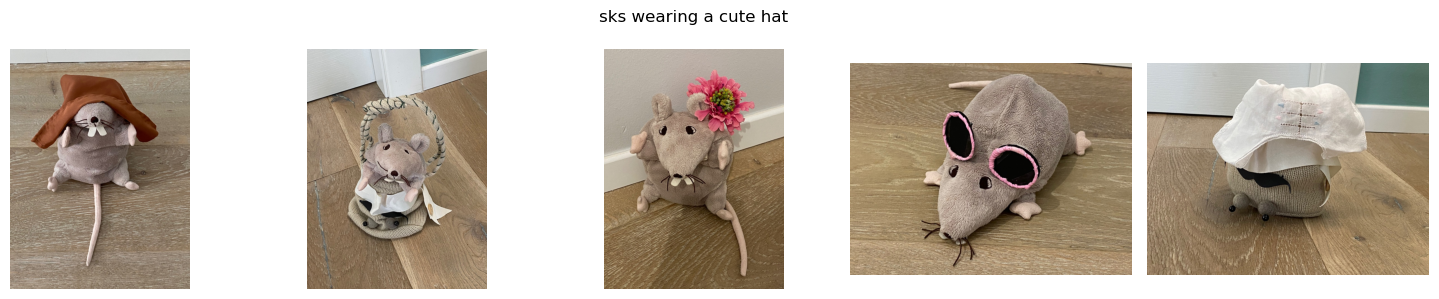

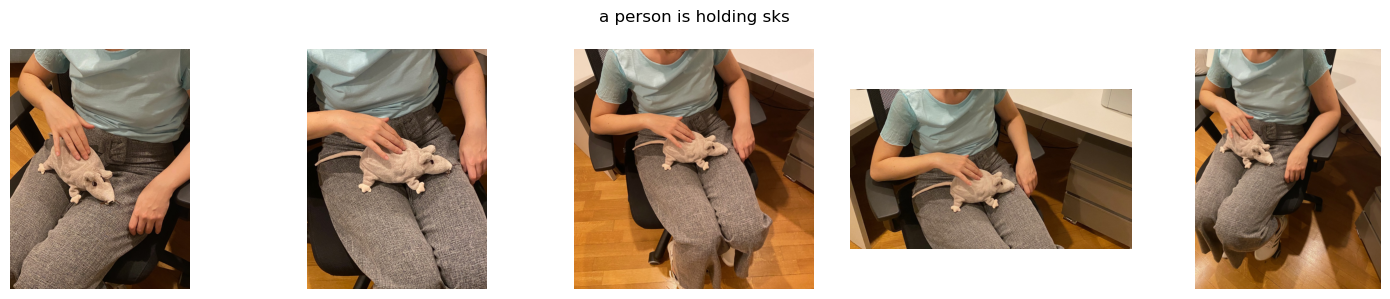

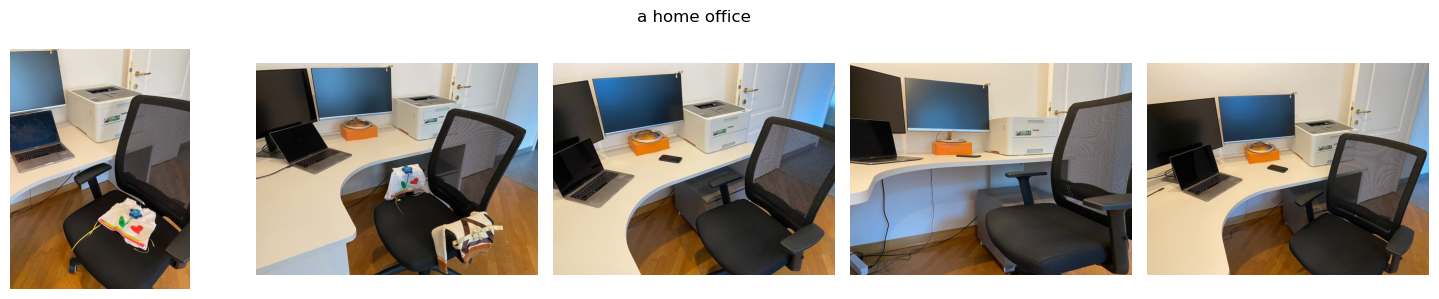

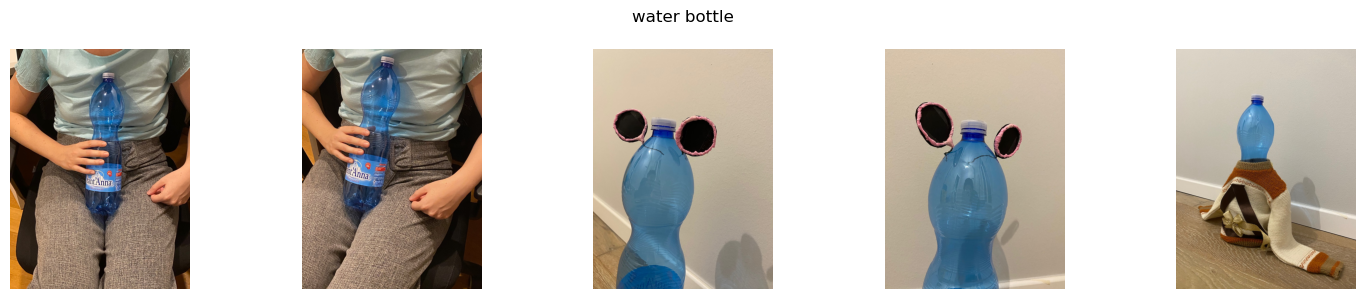

In [27]:
# visualize top 5 retrievals for different text queries

retrieval_queries = [
    "A photo of {}".format(concept_identifier),
    "{} listening to music by the window".format(concept_identifier),
    "{} sitting on a chair".format(concept_identifier), 
    "a doll and {} are together".format(concept_identifier),
    "{} wearing a cute hat".format(concept_identifier),
    "a person is holding {}".format(concept_identifier),
    "a home office", # general (non personal) retrieval
    "water bottle" # general (non personal) retrieval
]

text_tokens = clip.tokenize(retrieval_queries).to(device)
with torch.no_grad():
    test_prompt_embeddings = torch.nn.functional.normalize(model.encode_text_with_v_update(text_tokens, v_lora_A, v_lora_B), dim=-1)

sim = test_prompt_embeddings.cpu() @ retrieval_feats.T
ranks = np.argsort(-sim, axis=1)

k = 5
for i in range(len(retrieval_queries)):
    top_k_imgs = [retrieval_images[idx] for idx in ranks[i][0:k]]
    visualize_images_from_paths(top_k_imgs, plt_title=retrieval_queries[i])